# v2.1 exploration trying to make it work better

In [1]:
# Environment
import os
import os.path as osp
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import sys
# Local modules
sys.path.append('..')
import reproducibility
import pandas as pd
from utils import print_dict_summary
from data_funcs import rmse, process_train_dict
from moisture_rnn import RNNParams, RNNData, RNN, RNN_LSTM
from moisture_rnn_pkl import pkl2train
from tensorflow.keras.callbacks import Callback
from utils import hash2
import copy
import logging
import pickle
from utils import logging_setup, read_yml, read_pkl, hash_ndarray, hash_weights
import yaml
import copy

In [2]:
logging_setup()

## Tests

## Test Other ML

In [ ]:
params = read_yml("params.yaml", subkey='xgb')
params

In [ ]:
dat = read_pkl("data/train.pkl")

In [ ]:
cases = [*dat.keys()]

In [ ]:
rnn_dat = RNNData(dat[cases[10]], params['scaler'], params['features_list'])
rnn_dat.train_test_split(
    time_fracs = [.8, .1, .1]
)
rnn_dat.scale_data()

In [ ]:
from moisture_models import XGB, RF, LM

In [ ]:
mod = XGB(params)

In [ ]:
mod.params

In [ ]:
mod.fit(rnn_dat.X_train, rnn_dat.y_train)

In [ ]:
preds = mod.predict(rnn_dat.X_test)

In [ ]:
rmse(preds, rnn_dat.y_test)

In [ ]:
plt.plot(rnn_dat.y_test)
plt.plot(preds)

In [ ]:
params = read_yml("params.yaml", subkey='rf')
rnn_dat = RNNData(dat[cases[10]], features_list = ['Ed', 'Ew', 'solar', 'wind', 'rain'])
rnn_dat.train_test_split(
    time_fracs = [.8, .1, .1]
)

In [ ]:
import importlib
import moisture_models
importlib.reload(moisture_models)

In [ ]:
params

In [ ]:
mod2 = RF(params)
mod2.fit(rnn_dat.X_train, rnn_dat.y_train.flatten())
preds2 = mod2.predict(rnn_dat.X_test)
print(rmse(preds2, rnn_dat.y_test.flatten()))
plt.plot(rnn_dat.y_test)
plt.plot(preds2)

In [ ]:
from moisture_models import RF
mod2 = RF(params)

In [ ]:
params = read_yml("params.yaml", subkey='lm')
rnn_dat = RNNData(dat[cases[10]], features_list = ['Ed', 'Ew', 'solar', 'wind', 'rain'])
rnn_dat.train_test_split(
    time_fracs = [.8, .1, .1]
)
mod = LM(params)

In [ ]:
mod.fit(rnn_dat.X_train, rnn_dat.y_train)
preds = mod.predict(rnn_dat.X_test)
print(rmse(preds2, rnn_dat.y_test.flatten()))

## RNN

In [4]:
from utils import retrieve_url
retrieve_url(
    url = "https://demo.openwfm.org/web/data/fmda/dicts/raws_rocky_202305-202405.pkl", 
    dest_path = "data/fmda_rocky_202403-05_f05.pkl")

Target data already exists at data/fmda_rocky_202403-05_f05.pkl


In [5]:
from utils import read_pkl, read_yml
dat = read_pkl("data/fmda_rocky_202403-05_f05.pkl")

loading file data/fmda_rocky_202403-05_f05.pkl


In [6]:
from data_funcs import process_train_dict

In [7]:
params_data = read_yml("params_data.yaml")

In [8]:
params_data

{'max_intp_time': 10,
 'zero_lag_threshold': 10,
 'hours': 720,
 'min_fm': 1,
 'max_fm': 90,
 'min_rain': 0,
 'max_rain': 100,
 'min_wind': 0,
 'max_wind': 35,
 'min_solar': 0,
 'max_solar': 1400,
 'min_soilm': 0,
 'features_all': ['Ed',
  'Ew',
  'solar',
  'wind',
  'elev',
  'lon',
  'lat',
  'soilm',
  'canopyw',
  'groundflux',
  'rain']}

In [9]:
train = process_train_dict(["data/fmda_rocky_202403-05_f05.pkl"], atm_dict="RAWS", params_data = params_data, verbose=True)

2024-10-01 10:55:26,014 - INFO - PLFI1_202401 RAWS.time time array increments are 1.0 hours
2024-10-01 10:55:26,078 - INFO - PLFI1_202401 RAWS.time_raws time array increments are min 1.0 max 2.0
2024-10-01 10:55:26,167 - INFO - SADI1_202401 RAWS.time time array increments are 1.0 hours
2024-10-01 10:55:26,224 - INFO - SADI1_202401 RAWS.time_raws time array increments are min 1.0 max 3.0
2024-10-01 10:55:26,301 - INFO - SRFI1_202401 RAWS.time time array increments are 1.0 hours
2024-10-01 10:55:26,354 - INFO - SRFI1_202401 RAWS.time_raws time array increments are min 1.0 max 2.0
2024-10-01 10:55:26,431 - INFO - WEFI1_202401 RAWS.time time array increments are 1.0 hours
2024-10-01 10:55:26,485 - INFO - WEFI1_202401 RAWS.time_raws time array increments are min 1.0 max 2.0
2024-10-01 10:55:26,561 - INFO - AGFO3_202401 RAWS.time time array increments are 1.0 hours
2024-10-01 10:55:26,615 - INFO - AGFO3_202401 RAWS.time_raws time array increments are min 1.0 max 4.0
2024-10-01 10:55:26,708 -

In [10]:
from data_funcs import combine_nested, subset_by_features

In [11]:
train = subset_by_features(train, ['Ed', 'Ew', 'solar', 'wind', 'elev', 'lon', 'lat', 'rain'])

Subsetting to cases with features: ['Ed', 'Ew', 'solar', 'wind', 'elev', 'lon', 'lat', 'rain']


In [12]:
train = combine_nested(train)

In [17]:
import importlib
import moisture_rnn
importlib.reload(moisture_rnn)
from moisture_rnn import RNN, RNNData, staircase_spatial

In [18]:
params = RNNParams(read_yml("params.yaml", subkey="rnn"))
params.update({'features_list': ['Ed', 'Ew', 'solar', 'wind', 'rain', 'lon', 'lat', 'elev']})

Checking params...
Input dictionary passed all checks.
Calculating shape params based on features list, timesteps, and batch size
Input Feature List: ['Ed', 'Ew', 'rain']
Input Timesteps: 12
Input Batch Size: 32
Calculated params:
Number of features: 3
Batch Shape: (32, 12, 3)
{'batch_size': 32, 'timesteps': 12, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 1, 'dense_units': 5, 'activation': ['relu', 'relu'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type': 'exp', 'bmin': 20, 'bmax': 200, 'epochs': 20, 'learning_rate': 0.001, 'clipvalue': 10.0, 'phys_initialize': False, 'stateful': True, 'verbose_weights': True, 'verbose_fit': False, 'features_list': ['Ed', 'Ew', 'rain'], 'scale': True, 'scaler': 'standard', 'time_fracs': [0.9, 0.05, 0.05], 'early_stopping_patience': 5, 'predict_spinup_hours': 5, 'n_features': 3, 'batch_shape': (32, 12, 3)}
Calculating shape params based on features list, timesteps, and batch size
In

In [19]:
rnn_dat = RNNData(train, scaler = params['scaler'], 
                  features_list = ['Ed', 'Ew', 'solar', 'wind', 'rain', 'lon', 'lat', 'elev'])
rnn_dat.train_test_split(
    time_fracs = [.8, .1, .1],
    space_fracs = [.8, .1, .1]
)
rnn_dat.scale_data()

Input data from multiple timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'solar', 'wind', 'rain', 'lon', 'lat', 'elev']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
Subsetting locations into train/val/test
Total Locations: 333
Train Locations: 266
Val. Locations: 33
Test Locations: 34
X_train[0] shape: (576, 8), y_train[0] shape: (576, 1)
X_val[0] shape: (72, 8), y_val[0] shape: (72, 1)
X_test[0] shape: (72, 8), y_test[0] shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train


In [20]:
rnn_dat.batch_reshape(
    timesteps = params['timesteps'], 
    batch_size = params['batch_size'],
    start_times = np.zeros(len(rnn_dat.loc['train_locs'])),
    verbose=False
)

Reshaping spatial training data using batch size: 32 and timesteps: 12
Setting total hours to minimum length of y in provided dictionary
Reshaping validation data using batch size: 32 and timesteps: 12
Setting total hours to minimum length of y in provided dictionary
Reshaping test data by stacking. Output dimension will be (n_locs, test_hours, features)
X_test shape: (34, 72, 8)
y_test shape: (34, 72, 1)


In [21]:
len(rnn_dat.loc['test_locs'])

34

In [22]:
rnn_dat.X_train.shape

(13824, 12, 8)

In [23]:
rnn_dat.X_test.shape

(34, 72, 8)

In [27]:
params.update({
    'activation': ['tanh', 'tanh']
})

resetting random seeds to 123
Initial Weights Hash: ab01323d328b24a40ec4a7046119f888
Training simple RNN with params: {'batch_size': 32, 'timesteps': 12, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 1, 'dense_units': 5, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type': 'exp', 'bmin': 20, 'bmax': 200, 'epochs': 20, 'learning_rate': 0.001, 'clipvalue': 10.0, 'phys_initialize': False, 'stateful': True, 'verbose_weights': True, 'verbose_fit': False, 'features_list': ['Ed', 'Ew', 'solar', 'wind', 'rain', 'lon', 'lat', 'elev'], 'scale': True, 'scaler': 'standard', 'time_fracs': [0.9, 0.05, 0.05], 'early_stopping_patience': 5, 'predict_spinup_hours': 5, 'n_features': 8, 'batch_shape': (32, 12, 8)}
Using ResetStatesCallback with Batch Reset Schedule: exp
batch_reset_intervals: [ 20  22  25  28  31  35  39  44  50  56  63  70  79  89 100 112 126 141
 158 200]
Using early stopping callback.
Form

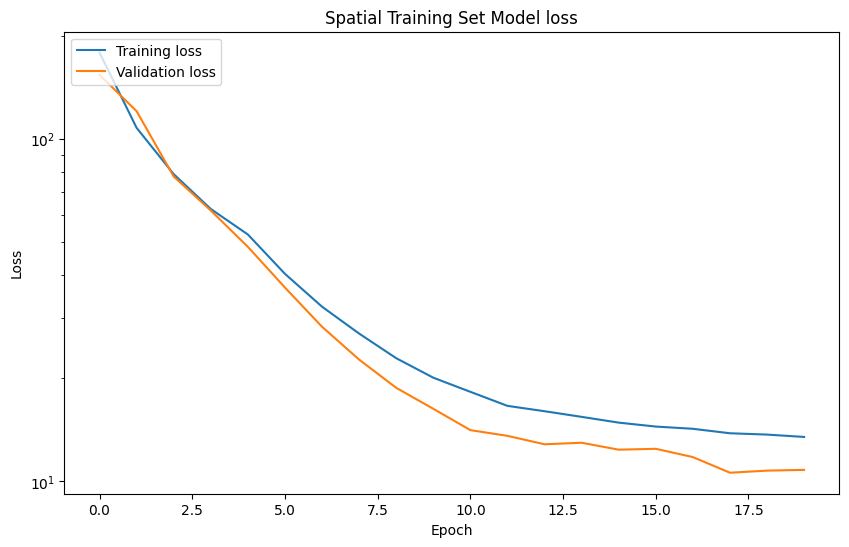

Fitted Weights Hash: 3bb6e92420484f2e8d47fa0786ce047e
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


In [28]:
reproducibility.set_seed()
rnn = RNN(params)
m, errs = rnn.run_model(rnn_dat)

In [29]:
errs.mean()

3.246332843132488

In [40]:
train.keys()

dict_keys(['id', 'case', 'filename', 'time', 'X', 'y', 'loc', 'features_list'])

In [136]:
import importlib
import data_funcs
importlib.reload(data_funcs)
from data_funcs import process_train_dict

In [137]:
params_data.update({
    'hours': 168,
    'features_all': ['Ed', 'Ew', 'solar', 'wind', 'groundflux', 'elev', 'lon', 'lat', 'doy', 'hod', 'rain']
})

In [138]:
train2 = process_train_dict(["data/test_CA_202401.pkl"], atm_dict="HRRR", params_data = params_data, verbose=True)

2024-10-01 11:58:14,344 - INFO - CNFC1_202401 HRRR.time time array increments are 1.0 hours
2024-10-01 11:58:14,347 - INFO - CNFC1_202401 RAWS.time_raws time array increments are min 1.0 max 2.0
2024-10-01 11:58:14,351 - INFO - CRVC1_202401 HRRR.time time array increments are 1.0 hours
2024-10-01 11:58:14,355 - INFO - CRVC1_202401 RAWS.time_raws time array increments are min 1.0 max 2.0
2024-10-01 11:58:14,360 - INFO - FCHC1_202401 HRRR.time time array increments are 1.0 hours
2024-10-01 11:58:14,363 - INFO - FCHC1_202401 RAWS.time_raws time array increments are min 1.0 max 2.0
2024-10-01 11:58:14,367 - INFO - FTNC1_202401 HRRR.time time array increments are 1.0 hours
2024-10-01 11:58:14,370 - INFO - FTNC1_202401 RAWS.time_raws time array increments are min 1.0 max 2.0
2024-10-01 11:58:14,373 - INFO - HTRC1_202401 HRRR.time time array increments are 1.0 hours
2024-10-01 11:58:14,378 - INFO - HTRC1_202401 RAWS.time_raws time array increments are min 1.0 max 2.0
2024-10-01 11:58:14,383 -

In [139]:
train3 = process_train_dict(["data/test_CA_202401.pkl"], atm_dict="HRRR", params_data = params_data, verbose=True, spatial=True)

2024-10-01 11:58:15,766 - INFO - CNFC1_202401 HRRR.time time array increments are 1.0 hours
2024-10-01 11:58:15,769 - INFO - CNFC1_202401 RAWS.time_raws time array increments are min 1.0 max 2.0
2024-10-01 11:58:15,772 - INFO - CRVC1_202401 HRRR.time time array increments are 1.0 hours
2024-10-01 11:58:15,776 - INFO - CRVC1_202401 RAWS.time_raws time array increments are min 1.0 max 2.0
2024-10-01 11:58:15,779 - INFO - FCHC1_202401 HRRR.time time array increments are 1.0 hours
2024-10-01 11:58:15,783 - INFO - FCHC1_202401 RAWS.time_raws time array increments are min 1.0 max 2.0
2024-10-01 11:58:15,787 - INFO - FTNC1_202401 HRRR.time time array increments are 1.0 hours
2024-10-01 11:58:15,790 - INFO - FTNC1_202401 RAWS.time_raws time array increments are min 1.0 max 2.0
2024-10-01 11:58:15,794 - INFO - HTRC1_202401 HRRR.time time array increments are 1.0 hours
2024-10-01 11:58:15,797 - INFO - HTRC1_202401 RAWS.time_raws time array increments are min 1.0 max 2.0
2024-10-01 11:58:15,801 -

In [140]:
train3.keys()

dict_keys(['id', 'case', 'filename', 'time', 'X', 'y', 'loc', 'features_list'])

In [141]:
import importlib
import moisture_rnn
importlib.reload(moisture_rnn)
from moisture_rnn import RNNData

In [142]:
rnn_dat = RNNData(train3, scaler = params['scaler'], 
                  features_list = ['Ed', 'Ew', 'solar', 'wind', 'rain', 'lon', 'lat', 'elev', 'doy', 'hod'])

Input data from multiple timeseries.
Setting data scaler: standard


In [143]:
len(rnn_dat.features_list)

10

In [144]:
rnn_dat.X[0].shape

(168, 11)

In [145]:
rnn_dat.spatial

True

In [146]:
rnn_dat.train_test_split()

Subsetting input data to features_list: ['Ed', 'Ew', 'solar', 'wind', 'rain', 'lon', 'lat', 'elev', 'doy', 'hod']
Train index: 0 to 168
Validation index: 168 to 168
Test index: 168 to 168
Subsetting locations into train/val/test
Total Locations: 97
Train Locations: 97
Val. Locations: 0
Test Locations: 0
X_train[0] shape: (168, 10), y_train[0] shape: (168, 1)


In [147]:
rnn_dat.features_list

['Ed', 'Ew', 'solar', 'wind', 'rain', 'lon', 'lat', 'elev', 'doy', 'hod']

In [149]:
rnn_dat.X_train[0][:, -1]

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23.,  0.,  1.,
        2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14.,
       15., 16., 17., 18., 19., 20., 21., 22., 23.,  0.,  1.,  2.,  3.,
        4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16.,
       17., 18., 19., 20., 21., 22., 23.,  0.,  1.,  2.,  3.,  4.,  5.,
        6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16., 17., 18.,
       19., 20., 21., 22., 23.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,
        8.,  9., 10., 11., 12., 13., 14., 15., 16., 17., 18., 19., 20.,
       21., 22., 23.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.,
       10., 11., 12., 13., 14., 15., 16., 17., 18., 19., 20., 21., 22.,
       23.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.,
       12., 13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23.])

## Phys Initialized

In [ ]:
params.update({
    'epochs':100,
    'dense_layers': 0,
    'activation': ['relu', 'relu'],
    'phys_initialize': False,
    'dropout': [0,0]
})

In [ ]:
reproducibility.set_seed()
rnn = RNN(params)
m, errs = rnn.run_model(rnn_dat)

In [ ]:
rnn.model_train.summary()

In [ ]:
params.update({
    'phys_initialize': True,
    'scaler': None, # TODO
    'dense_layers': 0, # NOT including single Dense output layer which is hard-coded
    'activation': ['linear', 'linear'], # TODO tanh, relu the same
    'batch_schedule_type': None # Hopefully this isn't a necessity like before, but maybe it will help
})

In [ ]:
rnn_dat2 = RNNData(dat[cases[10]], params['scaler'], params['features_list'])
rnn_dat2.train_test_split(
    time_fracs = [.8, .1, .1]
)
rnn_dat2.batch_reshape(timesteps = params['timesteps'], batch_size = params['batch_size'])

In [ ]:
import importlib
import moisture_rnn
importlib.reload(moisture_rnn)
from moisture_rnn import RNN, RNNData

In [ ]:
reproducibility.set_seed()

rnn = RNN(params)

In [ ]:
m, errs = rnn.run_model(rnn_dat2)

In [ ]:
rnn.model_predict.get_weights()

In [ ]:
params['rnn_units']

In [ ]:
params.update({
    'phys_initialize': True,
    'scaler': None, # TODO
    'dense_layers': 0, # NOT including single Dense output layer which is hard-coded
    'activation': ['relu', 'relu'], # TODO tanh, relu the same
    'batch_schedule_type': None # Hopefully this isn't a necessity like before, but maybe it will help
})

In [ ]:
rnn_dat2 = RNNData(dat[cases[10]], params['scaler'], params['features_list'])
rnn_dat2.train_test_split(
    time_fracs = [.8, .1, .1]
)
rnn_dat2.batch_reshape(timesteps = params['timesteps'], batch_size = params['batch_size'])

In [ ]:
reproducibility.set_seed()

rnn = RNN(params)
m, errs = rnn.run_model(rnn_dat2)

## LSTM

TODO: FIX BELOW

In [ ]:
import importlib 
import moisture_rnn
importlib.reload(moisture_rnn)
from moisture_rnn import RNN_LSTM

In [ ]:
params = read_yml("params.yaml", subkey="lstm")
params = RNNParams(params)

In [ ]:
rnn_dat = RNNData(dat[cases[10]], params['scaler'], params['features_list'])
rnn_dat.train_test_split(
    time_fracs = [.8, .1, .1]
)
rnn_dat.scale_data()
rnn_dat.batch_reshape(timesteps = params['timesteps'], batch_size = params['batch_size'])

In [ ]:
from moisture_rnn import ResetStatesCallback, EarlyStoppingCallback
params.update({'epochs': 50, 'learning_rate': 0.001, 'verbose_fit': True, 'rnn_layers': 2, 'rnn_units': 20, 'dense_layers': 1, 'dense_units': 10,
              'activation': ['tanh', 'tanh'], 'features_list': rnn_dat.features_list,
              'batch_schedule_type':'exp', 'bmin': 10, 'bmax':rnn_dat.hours})
reproducibility.set_seed(123)
lstm = RNN_LSTM(params)

history = lstm.model_train.fit(rnn_dat.X_train, rnn_dat.y_train, 
                    batch_size = params['batch_size'], epochs=params['epochs'], 
                    callbacks = [ResetStatesCallback(params),
                                EarlyStoppingCallback(patience = 15)],
                   validation_data = (rnn_dat.X_val, rnn_dat.y_val))
              

In [ ]:
params.update({'epochs': 50, 'learning_rate': 0.001, 'verbose_fit': True, 'rnn_layers': 2, 'rnn_units': 20, 'dense_layers': 1, 'dense_units': 10,
              'activation': ['tanh', 'tanh'], 'features_list': rnn_dat.features_list,
              'batch_schedule_type':'exp', 'bmin': 10, 'bmax':rnn_dat.hours,
              'early_stopping_patience': 25})
reproducibility.set_seed(123)
lstm = RNN_LSTM(params)
m, errs = lstm.run_model(rnn_dat)

In [ ]:
rnn_dat.spatial

In [ ]:
params = RNNParams(read_yml("params.yaml", subkey='lstm'))
params

In [ ]:
train = read_pkl("data/train.pkl")

In [ ]:
from itertools import islice
train = {k: train[k] for k in islice(train, 100)}

In [ ]:
from data_funcs import combine_nested
rnn_dat_sp = RNNData(
    combine_nested(train), # input dictionary
    scaler="standard",  # data scaling type
    features_list = params['features_list'] # features for predicting outcome
)


rnn_dat_sp.train_test_split(   
    time_fracs = [.8, .1, .1], # Percent of total time steps used for train/val/test
    space_fracs = [.8, .1, .1] # Percent of total timeseries used for train/val/test
)
rnn_dat_sp.scale_data()

rnn_dat_sp.batch_reshape(
    timesteps = params['timesteps'], # Timesteps aka sequence length for RNN input data. 
    batch_size = params['batch_size'] # Number of samples of length timesteps for a single round of grad. descent
)

In [ ]:
params.update({
    'loc_batch_reset': rnn_dat_sp.n_seqs # Used to reset hidden state when location changes for a given batch
})

In [ ]:
rnn_sp = RNN_LSTM(params)
m_sp, errs = rnn_sp.run_model(rnn_dat_sp)

In [ ]:
errs.mean()